# Voting Classifier

In [1]:
import pandas as pd
import numpy as np
import joblib
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will import our knn, logistic regression and decision tree models.

In [4]:
knn = joblib.load("../models/knn_model.joblib")
lr = joblib.load("../models/logistic_regression_model.joblib")
dt = joblib.load("../models/decision_tree_model.joblib")

Now we can experiment with our Voting Classifier.

In [5]:
hard_ensemble = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
    ('knn', knn)], 
    voting='hard'
)

hard_ensemble.fit(X_train, y_train)

,estimators,"[('lr', ...), ('dt', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,np.float64(13.8)
,fit_intercept,True


In [6]:
y_train_pred = hard_ensemble.predict(X_train)
y_test_pred = hard_ensemble.predict(X_test)

Training Set Metrics:


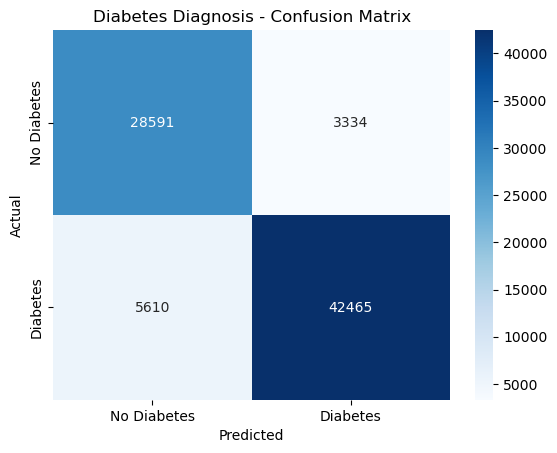

Accuracy: 0.8882
Precision: 0.9272036507347322
Recall: 0.8833073322932917
F1 Score: 0.9047233525789888


Test Set Metrics:


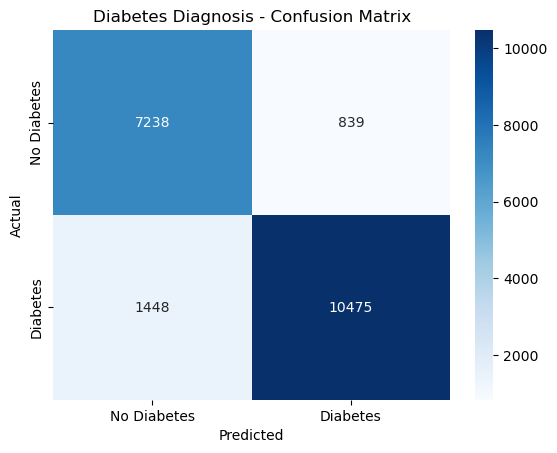

Accuracy: 0.88565
Precision: 0.9258440869718932
Recall: 0.8785540551874528
F1 Score: 0.9015793777165727


In [7]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This performance does not beat the decision tree model. We can exclusing KNN, since it is the worst performing model.

In [8]:
hard_ensemble2 = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
    ],
    voting='hard'
)

hard_ensemble2.fit(X_train, y_train)

,estimators,"[('lr', ...), ('dt', ...)]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,np.float64(13.8)
,fit_intercept,True


In [9]:
y_train_pred = hard_ensemble2.predict(X_train)
y_test_pred = hard_ensemble2.predict(X_test)

Training Set Metrics:


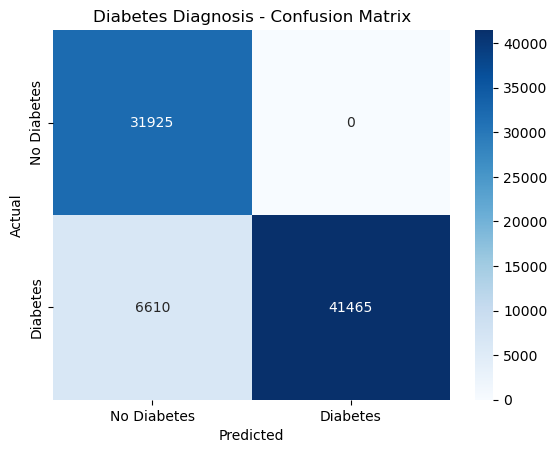

Accuracy: 0.917375
Precision: 1.0
Recall: 0.8625065002600104
F1 Score: 0.9261782443600626


Test Set Metrics:


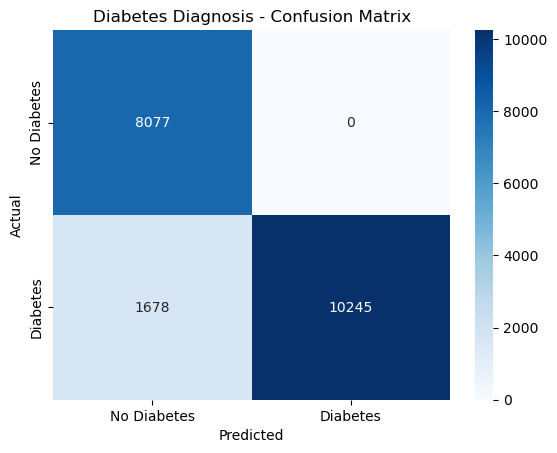

Accuracy: 0.9161
Precision: 1.0
Recall: 0.8592636081523106
F1 Score: 0.9243053049440635


In [10]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This is better, but still a bit worse than our decision tree model. We can try soft voting instead.

In [11]:
soft_ensemble = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
    ],
    voting='soft'
)

soft_ensemble.fit(X_train, y_train)

,estimators,"[('lr', ...), ('dt', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,np.float64(13.8)
,fit_intercept,True


In [12]:
y_train_pred = soft_ensemble.predict(X_train)
y_test_pred = soft_ensemble.predict(X_test)

Training Set Metrics:


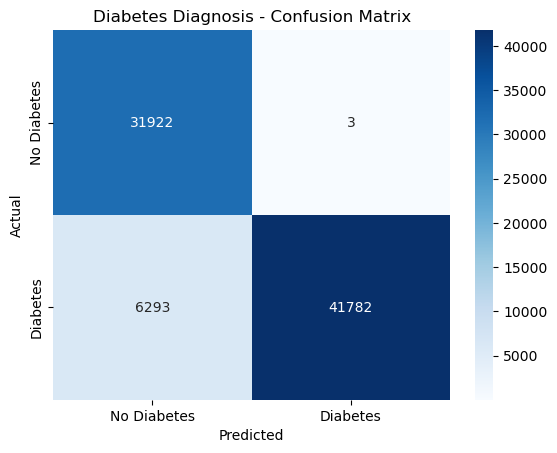

Accuracy: 0.9213
Precision: 0.9999282039009214
Recall: 0.8691003640145606
F1 Score: 0.9299354551524593


Test Set Metrics:


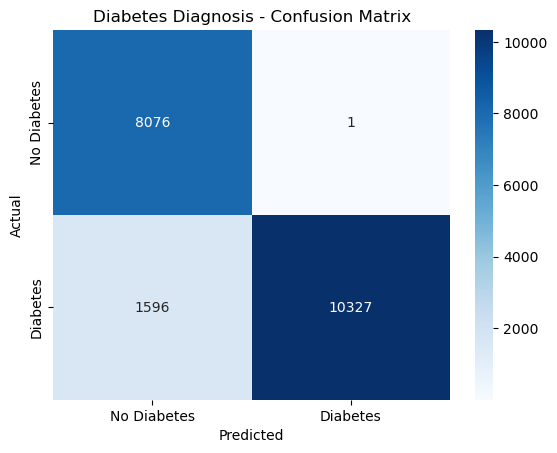

Accuracy: 0.92015
Precision: 0.9999031758326878
Recall: 0.866141071877883
F1 Score: 0.9282279448114692


In [13]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This classifier is now roughly on par with our decision tree model, although very marginally worse. We will not be adding knn here, since it only slows it down and tends to perform worse anyway. Instead, let us search for the optimal threshold for f1.

In [14]:
y_train_pred_proba = soft_ensemble.predict_proba(X_train)[:, 1]
y_test_pred_proba = soft_ensemble.predict_proba(X_test)[:, 1]

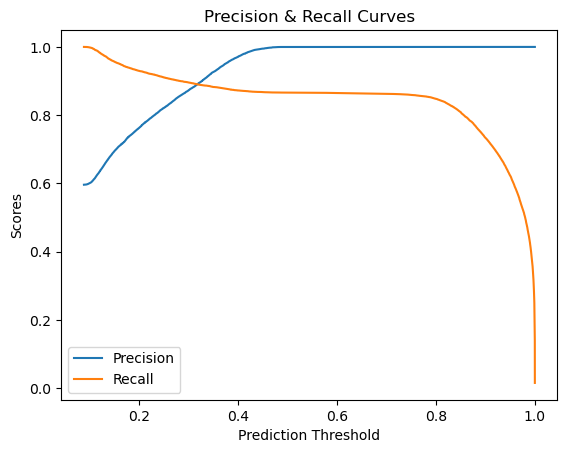

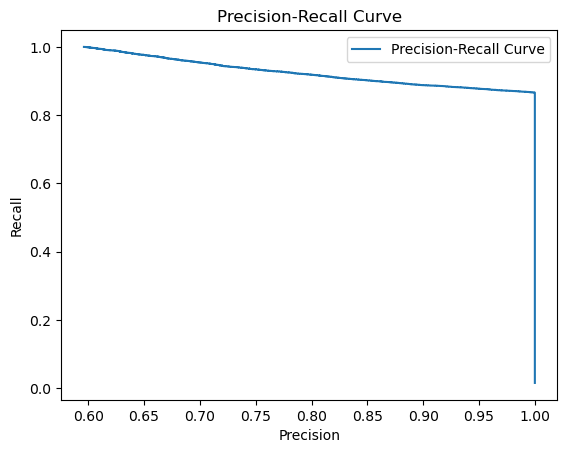

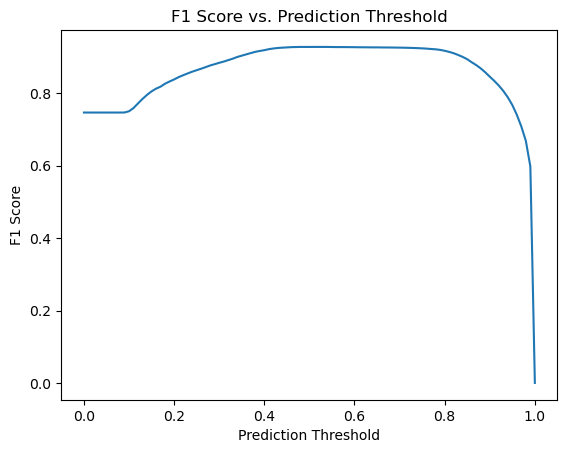

np.float64(0.51)

In [17]:
thresh =optimize_threshold(y_test, y_test_pred_proba)
thresh

The threshold is very close to the default 0.5. Still, let us see if there is any performance boost.

Training Set Metrics with Optimized Threshold:


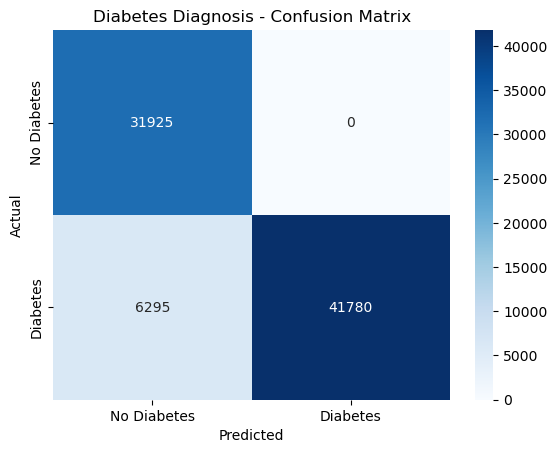

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics with Optimized Threshold:


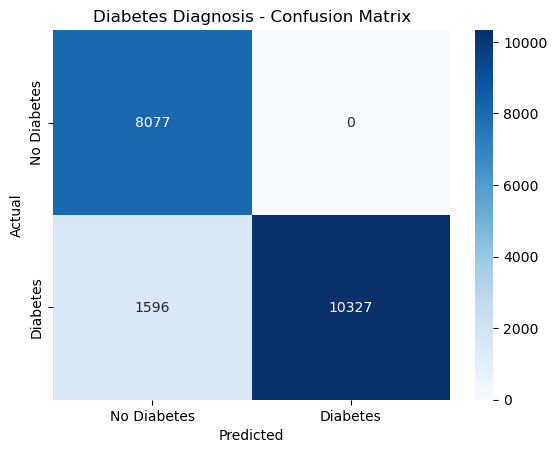

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [19]:
preds_train = y_train_pred_proba >= thresh
preds_test = y_test_pred_proba >= thresh

evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

This model performs exactly the same as the decision tree model. We can plot the ROC Curve and save it, nonetheless.

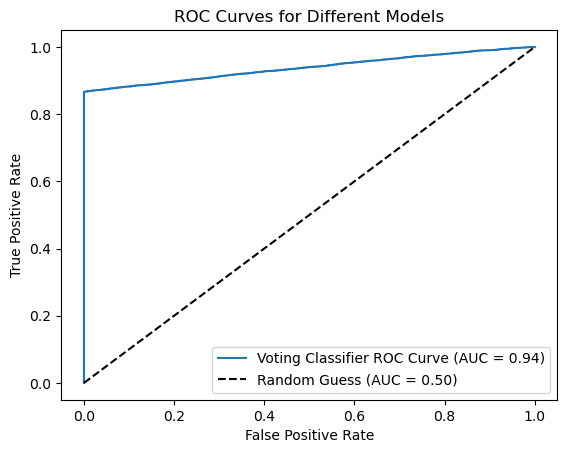

In [20]:
plot_roc_curve(y_test, y_test_pred_proba, "Voting Classifier ROC Curve")

The AUC seemingly improved by 0.01, which is not a major improvement, but it is the first time we see 0.94.

In [23]:
joblib.dump(soft_ensemble, "../models/voting_classifier_model.joblib")

['../models/voting_classifier_model.joblib']